In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use("seaborn-colorblind")
%matplotlib inline
# only displays the most important warnings
tf.logging.set_verbosity(tf.logging.FATAL)

Data Cleansing
---------

In [2]:
used_features = ['property_type','room_type','bathrooms','bedrooms','beds','bed_type','accommodates','host_total_listings_count'
                ,'number_of_reviews','review_scores_value','neighbourhood_cleansed','cleaning_fee','minimum_nights','security_deposit','host_is_superhost',
                 'instant_bookable', 'price']
boston = pd.read_csv('listings.csv', usecols = used_features)
print(boston.shape)
boston.head(2)

(3585, 17)


,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,minimum_nights,number_of_reviews,review_scores_value,instant_bookable
0,f,1,Roslindale,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,$250.00,NaN,$35.00,2,0,NaN,f
1,f,1,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,$65.00,$95.00,$10.00,2,36,9.0,t


In [3]:
for feature in ["cleaning_fee","security_deposit","price"]:
    boston[feature] = boston[feature].map(lambda x:x.replace("$",'').replace(",",''),na_action = 'ignore')
    boston[feature] = boston[feature].astype(float)
    boston[feature].fillna(boston[feature].median(),inplace = True)
    
    
for feature in ["bathrooms","bedrooms","beds","review_scores_value"]:
    boston[feature].fillna(boston[feature].median(),inplace = True)
    
boston['property_type'].fillna('Apartment',inplace = True)

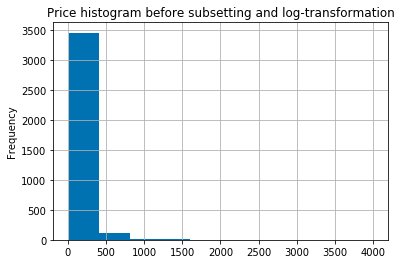

In [4]:
boston["price"].plot(kind = 'hist',grid = True)
plt.title("Price histogram before subsetting and log-transformation");

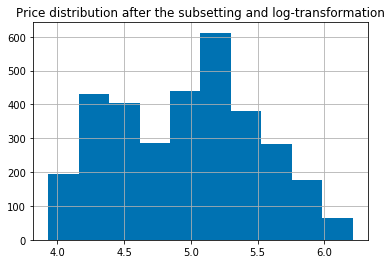

In [5]:
boston = boston[(boston["price"]>50)&(boston["price"]<500)]
target = np.log(boston.price)
target.hist()
plt.title("Price distribution after the subsetting and log-transformation");

In [6]:
features = boston.drop('price',axis=1)
features.head()

,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,security_deposit,cleaning_fee,minimum_nights,number_of_reviews,review_scores_value,instant_bookable
0,f,1,Roslindale,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,250.0,35.0,2,0,9.0,f
1,f,1,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,95.0,10.0,2,36,9.0,t
2,t,1,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,250.0,50.0,3,41,10.0,f
3,f,1,Roslindale,House,Private room,4,1.0,1.0,2.0,Real Bed,100.0,50.0,1,1,10.0,f
4,t,1,Roslindale,House,Private room,2,1.5,1.0,2.0,Real Bed,250.0,15.0,2,29,10.0,f


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     features, target, test_size=0.33, random_state=42)

- In Tensorflow, the models take Dense Tensors as input and outputs Dense Tensors
-  There are also other feature preprocessing steps like bucketization, scaling, crossing features, embedding etc people often take before feeding the data to the models. To simplify this process Tensorflow offers FeatureColumn abstraction.
- FeatureColumns handle the conversion of the spars or dense(numerical) features to a dense `Tensor usable by the core model`.

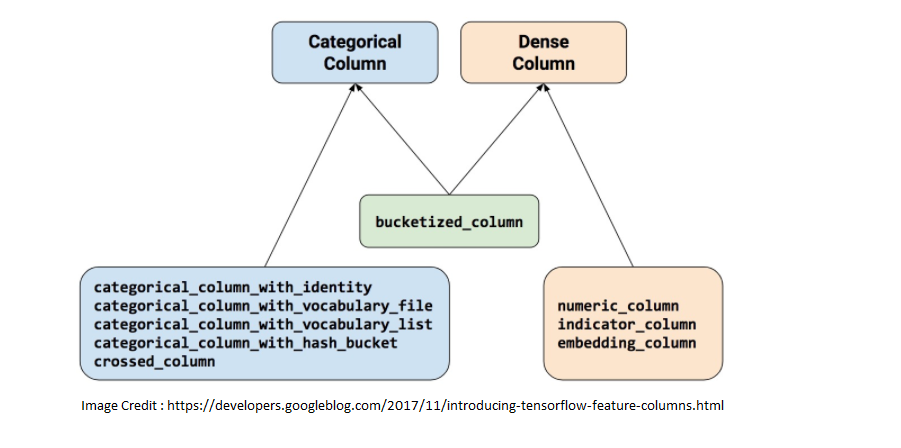

To learn more use https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html

#### Seperate Categorical and numerical

In [8]:
# Get all the numeric feature names
numeric_columns = ['host_total_listings_count','accommodates','bathrooms','bedrooms','beds',
 'security_deposit','cleaning_fee','minimum_nights','number_of_reviews',
 'review_scores_value']
# Get all the categorical feature names that contains strings
categorical_columns = ['host_is_superhost','neighbourhood_cleansed','property_type','room_type','bed_type','instant_bookable']

#### For Numerical columns

- When we create a numeric_column we have to pass a unique string to its e key parameter. 
- The value of key will be used as the name of the column.

In [12]:
numeric_features = [tf.feature_column.numeric_column(key = column) for column in numeric_columns]
print(numeric_features[0])

_NumericColumn(key='host_total_listings_count', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)


#### For Categorical columns

- here are many ways to handle categorical features in tensorflow. `categorical_column_with_vocabulary_list` is just one of them
- `categorical_column_with_vocabulary_list` must have following inputs :

    - key : a unique string identifying the input feature which would be used as the name of the column.
    - vocabulary_list : An ordered list defining the possible values for this categorical feature
- Other feature columns for categorical features are :

    - `categorical_column_with_identity` : Returns the column as it is.
    - `categorical_column_from_vocabulary_file` : Instad of giving the column values in a list, we read it from a file.
    - `categorical_column_with_hash_bucket` : If the number of values a categorical column can take is really large, instead of writing all the possible values in a list and giving it , we can use hashing to let tensorflow take care of it behind the scene. But there's a chance of 'hash collision' where two or more categories can be mapped to same place.
    - `crossed_column` : We can cross a categorical feature with a numerical or another categorical feature. For example, let's say we take a categorical feature "Gender" and another feature "Education", we can create new features like "female_x_phd" or "female_x_bachelors".

In [13]:
categorical_features = [tf.feature_column.categorical_column_with_vocabulary_list(key = column, 
                                                                                 vocabulary_list = features[column].unique()) 
                                                                                for column in categorical_columns]
print(categorical_features[3])

_VocabularyListCategoricalColumn(key='room_type', vocabulary_list=('Entire home/apt', 'Private room', 'Shared room'), dtype=tf.string, default_value=-1, num_oov_buckets=0)


#### Cobining the features

In [33]:
linear_features = numeric_features + categorical_features

## Building input function

- Estimators require that we use an input function for passing the features and the labels to the model.
- The input function must return a tuple containing two elements.
    - A dictionary that contains the feature column names as key and maps them to the tensors containing the feature data for a training batch.
    - A list of labels for the training batch
    
For more reading https://www.tensorflow.org/guide/datasets_for_estimators

- tensorflow provides functionality for feeding a pandas Dataframe straight into a tensorflow estimator with the pandas_input_fn function. 
-  Here we create two input functions training_input_fn and eval_input_fn that takes the training and test set features and labels respectively

In [15]:
training_input_fn = tf.estimator.inputs.pandas_input_fn(x = X_train,
                                                        y=y_train,
                                                        batch_size=32,
                                                        shuffle= True,
                                                        num_epochs = None)

In [16]:
eval_input_fn = tf.estimator.inputs.pandas_input_fn(x=X_test,
                                                    y=y_test,
                                                    batch_size=32,
                                                    shuffle=False,
                                                    num_epochs = 1)

### Instantiate the model

In [35]:
linear_regressor = tf.estimator.LinearRegressor(feature_columns=linear_features,
                                                model_dir = "linear_regressor")

### Train the model

In [36]:
linear_regressor.train(input_fn = training_input_fn,steps=2000)

### Evaluate the model

In [37]:
linear_regressor.evaluate(input_fn = eval_input_fn)

{'average_loss': 0.17193896,
 'label/mean': 4.976269,
 'loss': 5.4565334,
 'prediction/mean': 4.88605,
 'global_step': 6000}

In [38]:
pred = list(linear_regressor.predict(input_fn = eval_input_fn))
pred = [p['predictions'][0] for p in pred]